# Clustering Using Bernoulli mixture model
In this notebook, we will use the Bernoulli mixture model to cluster the digits dataset. We have 600 images  3 digits 2,3 and 4. We will create a Bernoulli mixture model which will estimate the mu for each pixel for each of the 3 classes. We will at last check how good the parameters are, and how accurately they have clustered the data.

In [5]:
# import the mnist data set
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data Preprocessing
We will use the given csv file and load the data as a pandas dataframe. We will then convert the features to binary values, so that we can treat them as a Bernoulli random variable.

In [6]:
df = pd.read_csv('mnist234.csv')
# drop the first column
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualising the original images
We will plot  some randokm original images.

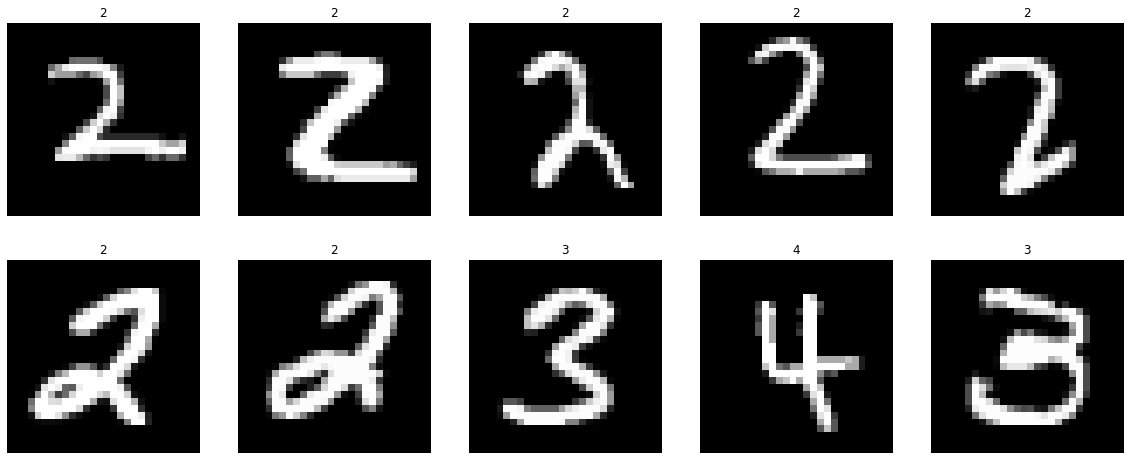

In [8]:
# lets see some sample images from the dataset
rand_index = np.random.randint(0, len(df), size=10)
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(df.iloc[rand_index[i]][1:].values.reshape(28, 28), cmap='gray')
    ax[i // 5, i % 5].set_title(df.iloc[rand_index[i]][0])
    ax[i // 5, i % 5].axis('off')


### Transforming the data to binary values and visualising the images
We will transform the data to binary values and plot the images, as we did above.

In [9]:
# convert the features to 0 to 1
# 0 to 255/2 will be 0 while 255/2 to 255 will be 1
df.iloc[:, 1:] = df.iloc[:, 1:] // 128

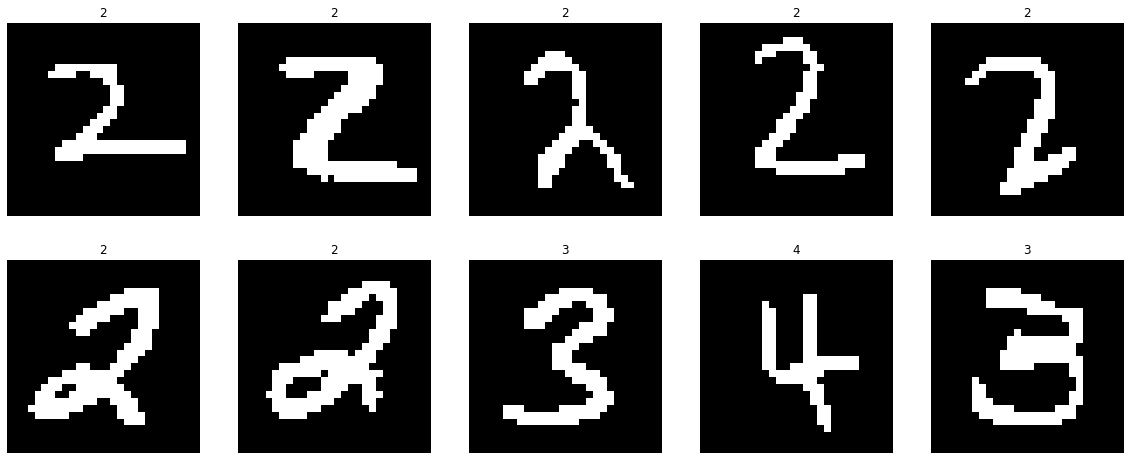

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(df.iloc[rand_index[i]][1:].values.reshape(28, 28), cmap='gray')
    ax[i // 5, i % 5].set_title(df.iloc[rand_index[i]][0])
    ax[i // 5, i % 5].axis('off')


## Bernouli Mixture Model
We have created a class for the Bernoulli mixture model. We will now fit the model to the data using this class, the class based approach is more convenient than the function based approach, as we can store all the data, parameters and results in the class.

The approach we have taken exactly follows the one given in the Bishop's book section 9.3.3 on page 444 and 445. 

In [11]:
class BernouliMixture:
    def __init__(self):
        self.gamma = None
        self.mu = None
        self.pi = None
        self.k = None
        
    def gamma_nk(self, X, n, k):
        gamma = self.pi[k] * self.bernouli_pdf(X[n], self.mu[k])
        denom = 0
        for i in range(self.k):
            denom += self.pi[i] * self.bernouli_pdf(X[n], self.mu[i])
        if denom == 0:
            return 0.
        return gamma / denom

    def N_k(self, X, k):
        N = X.shape[0]
        Nk=0 
        for i in range(N):
            Nk += self.gamma[i, k]  # N_k will be number of point in kth cluster!  It will be anumber
        return Nk

    def X_k(self, X, k):
        X_k = np.zeros(X.shape[1])
        for n in range(X.shape[0]):
            X_k += self.gamma[n, k] * X[n]
        return X_k / self.N_k(X, k)
        

    def Mu_k(self, X, k):
        mu_k = self.X_k(X, k)
        return mu_k

    def Pi_k(self, X, k):
        N_k = self.N_k(X, k)
        return N_k / X.shape[0]

    def bernouli_pdf(self, x, mu):
        pdf = 1
        for i in range(len(x)):
            pdf *= (mu[i] ** x[i]) * ((1 - mu[i]) ** (1 - x[i]))
        return pdf
    
    def predict(self, x):
        prob = np.zeros(self.k)
        for k in range(self.k):
            prob[k] = self.pi[k] * self.bernouli_pdf(x, self.mu[k])
        return prob.argmax()

    
    def fit(self, X, k, max_iter=100):
        self.k = k
        self.pi = np.ones(k) / k
        # initialize the mu between 0.25 and 0.75
        self.mu = np.random.uniform(0.25, 0.75, size=(k, X.shape[1]))
        # normalise the rows of mu
        self.mu = self.mu / np.linalg.norm(self.mu, axis=1).reshape(-1, 1)
        
        self.gamma = np.zeros((X.shape[0], k))
        
        for i in range(max_iter):
            for n in range(X.shape[0]):
                for k in range(self.k):
                    self.gamma[n, k] = self.gamma_nk(X, n, k)
            for k in range(self.k):
                self.mu[k] = self.Mu_k(X, k)
                self.pi[k] = self.Pi_k(X, k)
        return self

In [12]:
bmm = BernouliMixture()
bmm.fit(df.iloc[0:600, 1:].values, 3)
mu = bmm.mu

## Taking a look at the parameters
We have estimated the parameters of the model, we can now take a look at them. The Mus will be Bernouli probabilities, So we can plot them to see how they look like as a heat map.

Then we will ask the user to name each cluster based on how they look like and then will calclulate the accuracy of the Mixture model.

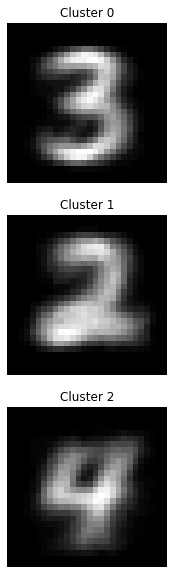

In [13]:
# plot mu for all three clusters
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
for i in range(3):
    ax[i].imshow(mu[i].reshape(28, 28), cmap='gray')
    ax[i].set_title('Cluster {}'.format(i))
    ax[i].axis('off')

In [14]:
# prompt the user to name the clusters
cluster_labels = {'cluster0': 0, 'cluster1': 1, 'cluster2': 2}
cluster_labels[0] = input('Enter the label for cluster 0: ')
cluster_labels[1] = input('Enter the label for cluster 1: ')
cluster_labels[2] = input('Enter the label for cluster 2: ')

In [ ]:
labels = np.zeros(df.shape[0])
for i in range(df.shape[0]):
    labels[i] = bmm.predict(df.iloc[i, 1:].values)
    labels[i] = cluster_labels[labels[i]]


Based on the labels assigned we will compare it with the true labels and find the accuracy.

In [ ]:
currect_cnt = 0
for i in range(df.shape[0]):
    if labels[i] == df.iloc[i, 0]:
        currect_cnt += 1

accuracy = currect_cnt / df.shape[0]
print('Accuracy: ', accuracy)


Accuracy:  0.805


We can see that the accuracy is around 80%, which is fair enough for such a simple model and small dataset.